In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd/content/drive/My Drive/Colab Notebooks/BTL AI4E
!ls

/content/drive/My Drive/Colab Notebooks/BTL AI4E
links.csv	 movies.csv   README.txt  turicreate
Movielens.ipynb  ratings.csv  tags.csv


In [ ]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


In [ ]:
ratings = pd.read_csv('ratings.csv')
len(ratings)

100836

# Checking if the user has rated the same movie twice, in that case we just take max of them

In [ ]:
ratings_df = ratings.groupby(['userId','movieId']).aggregate(np.max)

In [ ]:
len(ratings_df)

100836

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings_df.head()

rating  timestamp
userId movieId                   
1      1           4.0  964982703
       3           4.0  964981247
       6           4.0  964982224
       47          5.0  964983815
       50          5.0  964982931

In [ ]:
len(ratings['userId'].unique())

610

In [ ]:
count_ratings = ratings.groupby('rating').count()
count_ratings['perc_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)

In [ ]:
count_ratings

,userId,movieId,timestamp,perc_total
rating,,,,
0.5,1370,1370,1370,1.4
1.0,2811,2811,2811,2.8
1.5,1791,1791,1791,1.8
2.0,7551,7551,7551,7.5
2.5,5550,5550,5550,5.5
3.0,20047,20047,20047,19.9
3.5,13136,13136,13136,13.0
4.0,26818,26818,26818,26.6
4.5,8551,8551,8551,8.5


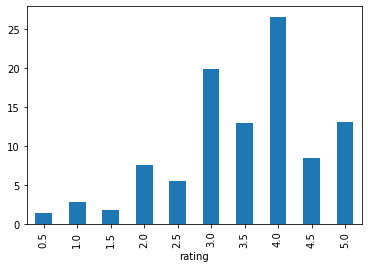

In [ ]:
count_ratings['perc_total'].plot.bar()

In [ ]:
movie_list = pd.read_csv('movies.csv')

In [ ]:
movie_list.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
tags = pd.read_csv('tags.csv')

In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [ ]:
genres = movie_list['genres']

In [ ]:
genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [ ]:
genre_list = ""
for index,row in movie_list.iterrows():
        genre_list += row.genres + "|"
#split the string into a list of values
genre_list_split = genre_list.split('|')
#de-duplicate values
new_list = list(set(genre_list_split))
#remove the value that is blank
new_list.remove('')
#inspect list of genres
new_list

['Thriller',
 '(no genres listed)',
 'Fantasy',
 'Children',
 'IMAX',
 'Drama',
 'Sci-Fi',
 'Comedy',
 'Romance',
 'Western',
 'Mystery',
 'Action',
 'War',
 'Animation',
 'Adventure',
 'Musical',
 'Crime',
 'Documentary',
 'Film-Noir',
 'Horror']

**Enriching the movies dataset by adding the various genres columns.**

In [ ]:
for genre in new_list :
    movie_list[genre] = movie_list.apply(lambda _:int(genre in _.genres), axis = 1)

In [ ]:
movie_list.head()

,movieId,title,genres,Romance,Musical,(no genres listed),War,Western,Mystery,Crime,Documentary,Horror,Comedy,Fantasy,Thriller,Drama,Children,Sci-Fi,Action,Adventure,Film-Noir,Animation,IMAX
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
movie_list['movieId'] = movie_list['movieId'].astype(object)

In [ ]:
movie_list.shape

(9742, 23)

**Calculating the sparsity**

In [ ]:
no_of_users = len(ratings['userId'].unique())
no_of_movies = len(ratings['movieId'].unique())

sparsity = round(1.0 - len(ratings)/(1.0*(no_of_movies*no_of_users)),3)
print(sparsity)

0.983


In [ ]:
#Counting the number of unique movies in the dataset
len(ratings['movieId'].unique())

9724

In [ ]:
avg_movie_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index

In [ ]:
avg_movie_rating.head()

,mean,count,movieId
movieId,,,
1,3.920930,215,1
2,3.431818,110,2
3,3.259615,52,3
4,2.357143,7,4
5,3.071429,49,5


In [ ]:
#Get the average movie rating across all movies 
avg_rating_all=ratings['rating'].mean()
avg_rating_all
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=5
min_reviews
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count,movieId
movieId,,,
1,3.920930,215,1
2,3.431818,110,2
3,3.259615,52,3
4,2.357143,7,4
5,3.071429,49,5


**Creating a function for weighted rating score based on the count of reviews**

In [ ]:
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

**Calculating the weighted score for each movie**

In [ ]:
movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
movie_score.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,mean,count,movieId,weighted_score
movieId,,,,
1,3.920930,215,1,3.911399
2,3.431818,110,2,3.434850
3,3.259615,52,3,3.280838
4,2.357143,7,4,2.833982
5,3.071429,49,5,3.111255


In [ ]:
movie_score = movie_score.drop(columns = 'movieId')

In [ ]:
movie_score.reset_index()

,movieId,mean,count,weighted_score
0,1,3.920930,215,3.911399
1,2,3.431818,110,3.434850
2,3,3.259615,52,3.280838
3,4,2.357143,7,2.833982
4,5,3.071429,49,3.111255
...,...,...,...,...
3263,177765,3.538462,13,3.528210
3264,179401,3.666667,6,3.591617
3265,179819,3.125000,12,3.235752
3266,180031,3.687500,8,3.615983


**Joining the movie details to the movie ratings**

In [ ]:
movie_score = pd.merge(movie_score,movie_list,on='movieId')
movie_score.head()

,movieId,mean,count,weighted_score,title,genres,Thriller,(no genres listed),Fantasy,Children,IMAX,Drama,Sci-Fi,Comedy,Romance,Western,Mystery,Action,War,Animation,Adventure,Musical,Crime,Documentary,Film-Noir,Horror
0,1,3.920930,215,3.911399,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
1,2,3.431818,110,3.434850,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,3.259615,52,3.280838,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,4,2.357143,7,2.833982,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,5,3.071429,49,3.111255,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
movie_score = pd.merge(movie_score,tags,on='movieId')

In [ ]:
movie_score.head()

,movieId,mean,count,weighted_score,title,genres,Thriller,(no genres listed),Fantasy,Children,IMAX,Drama,Sci-Fi,Comedy,Romance,Western,Mystery,Action,War,Animation,Adventure,Musical,Crime,Documentary,Film-Noir,Horror,userId,tag,timestamp
0,1,3.920930,215,3.911399,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,336,pixar,1139045764
1,1,3.920930,215,3.911399,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,474,pixar,1137206825
2,1,3.920930,215,3.911399,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,567,fun,1525286013
3,2,3.431818,110,3.434850,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,62,fantasy,1528843929
4,2,3.431818,110,3.434850,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,62,magic board game,1528843932


In [ ]:
movie_score.shape

(2962, 29)

**This function will give the best movies according to genre based on weighted score which is calculated using IMDB formula**

In [ ]:
def best_movies_by_genre(genre,top_n):
    d = pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']])
    d = d.drop_duplicates(keep = "first")
    return d[:top_n]

In [ ]:
#run function to return top recommended movies by genre
best_movies_by_genre('Comedy',10)

,title,count,mean,weighted_score
550,Dr. Strangelove or: How I Learned to Stop Worr...,97,4.268041,4.230468
766,"Princess Bride, The (1987)",142,4.232394,4.207536
574,"Philadelphia Story, The (1940)",29,4.310345,4.191405
319,Pulp Fiction (1994),307,4.197068,4.185922
835,Harold and Maude (1971),26,4.288462,4.161541
666,His Girl Friday (1940),14,4.392857,4.158304
1747,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",120,4.183333,4.156062
415,Forrest Gump (1994),329,4.164134,4.154215
738,Monty Python and the Holy Grail (1975),136,4.161765,4.138353
1180,Life Is Beautiful (La Vita è bella) (1997),88,4.147727,4.112987


**Just including the tag "Hollywood"**

In [ ]:
def best_movies_hollywood():
    d= pd.DataFrame(movie_score.loc[(movie_score["tag"]=="Hollywood")].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','tag']])
    d = d.drop_duplicates(keep = "first")
    e = pd.DataFrame(movie_score.loc[(movie_score["tag"]=="Hollywood")].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','tag']])
    e = e.drop_duplicates(keep = "first")
    e.append(d)
    return e

In [ ]:
best_movies_hollywood()

,title,count,mean,weighted_score,tag
653,All About Eve (1950),24,4.229167,4.103717,Hollywood
18,Get Shorty (1995),89,3.494382,3.494764,Hollywood
1689,America's Sweethearts (2001),18,2.583333,2.782947,Hollywood


 **Gives the best movies with HOLLYWOOD tag according to genre based on weighted score which is calculated using IMDB formula**

In [ ]:
def best_movies_by_genre(genre,top_n):
    d= pd.DataFrame(movie_score.loc[(movie_score[genre]==1) & ((movie_score["tag"]=="Hollywood") | (movie_score["tag"]=="Hollywood"))].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','tag']])
    d = d.drop_duplicates(keep = "first")
    return d[:top_n]

In [ ]:
best_movies_by_genre('Drama',10)

,title,count,mean,weighted_score,tag
653,All About Eve (1950),24,4.229167,4.103717,Hollywood


**> Get top movie recommendations by a combination of genres**

In [ ]:
# Gives the best movies according to 2 genres based on weighted score which is calculated using IMDB formula
def best_movies_by_collective_genre(genre1,genre2,top_n):
    d = pd.DataFrame(movie_score.loc[(movie_score[genre1]==1) & (movie_score[genre2]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']])
    d = d.drop_duplicates(keep = "first")
    return d[:top_n]

**COLLABORATIVE FILTERING USING K MEANS CLUSTERING ALGORITHM**

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
avg_movie_rating.head()

,mean,count,movieId
movieId,,,
1,3.920930,215,1
2,3.431818,110,2
3,3.259615,52,3
4,2.357143,7,4
5,3.071429,49,5


**Only include movies with more than 10 ratings**

In [ ]:
movie_plus_10_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=10]
print(len(movie_plus_10_ratings))

2269


In [ ]:
movie_plus_10_ratings = movie_plus_10_ratings.drop(columns='movieId')

In [ ]:
movie_plus_10_ratings = movie_plus_10_ratings.reset_index()

In [ ]:
movie_plus_10_ratings.head()

,movieId,mean,count
0,1,3.920930,215
1,2,3.431818,110
2,3,3.259615,52
3,5,3.071429,49
4,6,3.946078,102


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
filtered_ratings = pd.merge(movie_plus_10_ratings, ratings[:100000], on="movieId")

In [ ]:
#create a matrix table with movieIds on the rows and userIds in the columns.
#replace NAN values with 0
movie_wide = filtered_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_wide.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,0.0,0.0,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.5,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,4.5,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0


In [ ]:
#specify model parameters
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
#fit model to the data set
model_knn.fit(movie_wide)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
def print_similar_movies(query_index) :
    #get the list of user ratings for a specific userId
    query_index_movie_ratings = movie_wide.loc[query_index,:].values.reshape(1,-1)
    #get the closest 10 movies and their distances from the movie specified
    distances,indices = model_knn.kneighbors(query_index_movie_ratings,n_neighbors =9) 
    #write a lopp that prints the similar movies for a specified movie.
    for i in range(0,len(distances.flatten())):
        #get the title of the random movie that was chosen
        get_movie = movie_list.loc[movie_list['movieId']==query_index]['title']
        #for the first movie in the list i.e closest print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_movie))
        else :
            #get the indiciees for the closest movies
            indices_flat = indices.flatten()[i]
            #get the title of the movie
            get_movie = movie_list.loc[movie_list['movieId']==movie_wide.iloc[indices_flat,:].name]['title']
            #print the movie
            print('{0}: {1}, with distance of {2}:'.format(i,get_movie,distances.flatten()[i]))

In [ ]:
print_similar_movies(112552)

Recommendations for 8466    Whiplash (2014)
Name: title, dtype: object:

1: 8313    Her (2013)
Name: title, dtype: object, with distance of 0.39426426563443917:
2: 8452    Birdman: Or (The Unexpected Virtue of Ignoranc...
Name: title, dtype: object, with distance of 0.4207980362474828:
3: 8372    Grand Budapest Hotel, The (2014)
Name: title, dtype: object, with distance of 0.46354089266862375:
4: 8467    Gone Girl (2014)
Name: title, dtype: object, with distance of 0.4636212748574674:
5: 8376    Interstellar (2014)
Name: title, dtype: object, with distance of 0.473903187738281:
6: 8305    Wolf of Wall Street, The (2013)
Name: title, dtype: object, with distance of 0.5191213264132166:
7: 8550    Ex Machina (2015)
Name: title, dtype: object, with distance of 0.5219020886589144:
8: 8681    Mad Max: Fury Road (2015)
Name: title, dtype: object, with distance of 0.5424134349598271:


In [ ]:
print_similar_movies(1)

Recommendations for 0    Toy Story (1995)
Name: title, dtype: object:

1: 2355    Toy Story 2 (1999)
Name: title, dtype: object, with distance of 0.4273987396802844:
2: 418    Jurassic Park (1993)
Name: title, dtype: object, with distance of 0.4343631959138434:
3: 615    Independence Day (a.k.a. ID4) (1996)
Name: title, dtype: object, with distance of 0.43573830647233414:
4: 224    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object, with distance of 0.4426118294200634:
5: 314    Forrest Gump (1994)
Name: title, dtype: object, with distance of 0.45290409205982585:
6: 322    Lion King, The (1994)
Name: title, dtype: object, with distance of 0.4588546505397666:
7: 911    Star Wars: Episode VI - Return of the Jedi (1983)
Name: title, dtype: object, with distance of 0.458910695227416:
8: 546    Mission: Impossible (1996)
Name: title, dtype: object, with distance of 0.4610872294416424:


**Using only the title of the movie**

In [ ]:
tfidf = TfidfVectorizer(stop_words="english")
movie_list['title'] = movie_list['title'].fillna(" ")
overview_matrix = tfidf.fit_transform(movie_list['title'])
overview_matrix.shape

(9742, 9053)

In [ ]:
similarity_matrix = linear_kernel(overview_matrix,overview_matrix)
mapping = pd.Series(movie_list.index,index = movie_list["title"])
def recommend_movies(movie_input):
    movie_index = mapping[movie_input]
    #get similarity values with other movies
    #similarity_score is the list of index and similarity matrix
    similarity_score = list(enumerate(similarity_matrix[movie_index]))
    #sort in descending order the similarity score of movie inputted with all the other movies
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    # Get the scores of the 15 most similar movies. Ignore the first movie.
    similarity_score = similarity_score[1:15]
    #return movie names using the mapping series
    movie_indices = [i[0] for i in similarity_score]
    return (movie_list["title"].iloc[movie_indices])

In [ ]:
recommend_movies ("Toy Story 2 (1999)")

SyntaxError: ignored

**Creating : user - item matrix**

In [ ]:
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

In [ ]:
ratings_f.head

<bound method NDFrame.head of         userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[92729 rows x 4 columns]>

In [ ]:
ratings_f1 = pd.merge(movie_list[['movieId']], ratings_f, on="movieId", how="right")

In [ ]:
ratings_f.head

<bound method NDFrame.head of         movieId  rating   timestamp
0             1     4.0   964982703
1             1     4.0   847434962
2             1     4.5  1106635946
3             1     2.5  1510577970
4             1     4.5  1305696483
...         ...     ...         ...
100831   193581     4.0  1537109082
100832   193583     3.5  1537109545
100833   193585     3.5  1537109805
100834   193587     3.5  1537110021
100835   193609     4.0  1537157606

[100836 rows x 3 columns]>

In [ ]:

ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [ ]:
ratings_f2.head

<bound method NDFrame.head of userId   1    4    6    7    10   11   15   ...  603  604  605  606  607  608  610
movieId                                     ...                                   
1        4.0  0.0  0.0  4.5  0.0  0.0  2.5  ...  4.0  3.0  4.0  2.5  4.0  2.5  5.0
2        0.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  0.0  5.0  3.5  0.0  0.0  2.0  0.0
3        4.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  2.0  0.0
4        0.0  0.0  3.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5        0.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  3.0  0.0  0.0  0.0  0.0  0.0
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
193581   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
193583   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
193585   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
193587   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0

In [ ]:
ratings_f3=pd.merge(movie_list[['title','movieId']], ratings_f2, on="movieId", how="inner")

In [ ]:
ratings_f3.shape

(9625, 366)

In [ ]:
mo

In [ ]:

len(ratings_f.movieId.unique())

9625

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 5.2MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670963 sha256=9dd0f53df2aea2e8b2fb1cae1b9194b654518c7afb7ac7c575ba8297f91bd235
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


#**Use matrix factorization model:**

In [ ]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [ ]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_f[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.8624


0.8623834870559886

In [ ]:
Mapping_file = dict(zip(movie_list.title.tolist(), movie_list.movieId.tolist()))

In [ ]:
def pred_user_rating(ui):
    if ui in ratings_f.userId.unique():
        ui_list = ratings_f[ratings_f.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [ ]:
user_id =1
pred_user_rating(user_id)

,ratings
movies,
Wallace & Gromit: The Wrong Trousers (1993),5.0
There Will Be Blood (2007),5.0
"Shawshank Redemption, The (1994)",5.0
To Kill a Mockingbird (1962),5.0
Lawrence of Arabia (1962),5.0
"Godfather, The (1972)",5.0
One Flew Over the Cuckoo's Nest (1975),5.0
Raging Bull (1980),5.0
Little Big Man (1970),5.0


In [ ]:
ratings.head

<bound method NDFrame.head of         userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]>

**usee matrix factorization**

In [ ]:
from scipy import sparse
X = ratings_f1[['userID', 'movieID']].values
y = ratings_f1['ratings'].values
def ConvertToDense(X, y, shape):  # from R=(X,y), in sparse format 
    row  = X[:,0]
    col  = X[:,1]
    data = y
    matrix_sparse = sparse.csr_matrix((data,(row,col)), shape=(shape[0]+1,shape[1]+1))  # sparse matrix in compressed format (CSR)
    R = matrix_sparse.todense()   # convert sparse matrix to dense matrix, same as: matrix_sparse.A
    R = R[1:,1:]                  # removing the "Python starts at 0" offset
    R = np.asarray(R)             # convert matrix object to ndarray object
    return R
  
n_users = len(ratings['userId'].unique())
n_items = len(ratings['movieId'].unique())
R_shape = (n_users, n_items)

R = ConvertToDense(X, y, R_shape)
print(R)
print (R.shape)

KeyError: ignored

In [ ]:
def GetShape(filename):
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(filename, sep='\t', names=names)
    n_users = len(df['user_id'].unique())
    n_items = len(df['item_id'].unique())
    return (n_users, n_items)

def LoadData(filename, R_shape):
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(filename, sep='\t', names=names)   
    X = df[['user_id', 'item_id']].values
    y = df['rating'].values   
    return X, y, ConvertToDense(X, y, R_shape)
 
R_shape = GetShape('ml-100k/u.data') 
X, y, R = LoadData('ml-100k/u.data', R_shape)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
R_train,R_test=train_test_split(ratings_f2,test_size=0.33)

**Choose a model: NMF**

In [ ]:
from sklearn.decomposition import NMF

parametersNMF = {
                    'n_components' : 20,     # number of latent factors
                    'init' : 'random', 
                    'random_state' : 0, 
                    'alpha' : 0.01,          # regularization term
                    'l1_ratio' : 0,          # set regularization = L2 
                    'max_iter' : 15
                }

estimator = NMF(**parametersNMF)

**Estimating the error (RMSE) before tuning the hyperparameters**

In [ ]:
from sklearn.metrics import mean_squared_error

def get_rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten()     # Ignore nonzero terms
    actual = actual[actual.nonzero()].flatten() # Ignore nonzero terms
    return np.sqrt(mean_squared_error(pred, actual))

In [ ]:
err = 0
n_iter = 0.
n_folds = 5
for train_index, test_index in KFold( n_folds=5):   
    
    t0 = time.time()
    estimator.fit(R_train)  
    Theta = estimator.transform(R_train)       # user features
    M = estimator.components_.T                # item features
    print ("Fit in %0.3fs" % (time.time() - t0))
    n_iter += estimator.n_iter_ 

    # Making the predictions
    R_pred = M.dot(Theta.T)
    R_pred = R_pred.T      
    
    # Clipping values                                                    
    R_pred[R_pred > 5] = 5.           # clips ratings above 5             
    R_pred[R_pred < 1] = 1.           # clips ratings below 1

    # Computing the error on the validation set 
    err += get_rmse(R_pred, R_test)
    print(get_rmse(R_pred, R_test))
    
print ("*** RMSE Error : ", err / n_folds)
print ("Mean number of iterations:", n_iter / n_folds)

NameError: ignored